In [ ]:
! pip install -q --no-deps equinox diffrax jaxtyping lineax optimistix wadler-lindig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 6.0 MB/s eta 0:00:00


In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import itertools
import equinox as eqx
import optax
import diffrax
import time

from jax import grad, random, config, vmap, jit
from jax.lax import scan, dot_general
from jax.nn import relu, gelu, sigmoid, softmax, log_softmax
from jax.tree_util import tree_map, tree_flatten
from numpy import genfromtxt

from tqdm import tqdm

%config InlineBackend.figure_format='retina'

In [ ]:
my_data = genfromtxt('/content/sample_data/mnist_test.csv', delimiter=',')
features = jnp.array(my_data[:, 1:])
targets = jnp.array(my_data[:, 0]).astype(int)
features.shape, targets.shape

((10000, 784), (10000,))

3


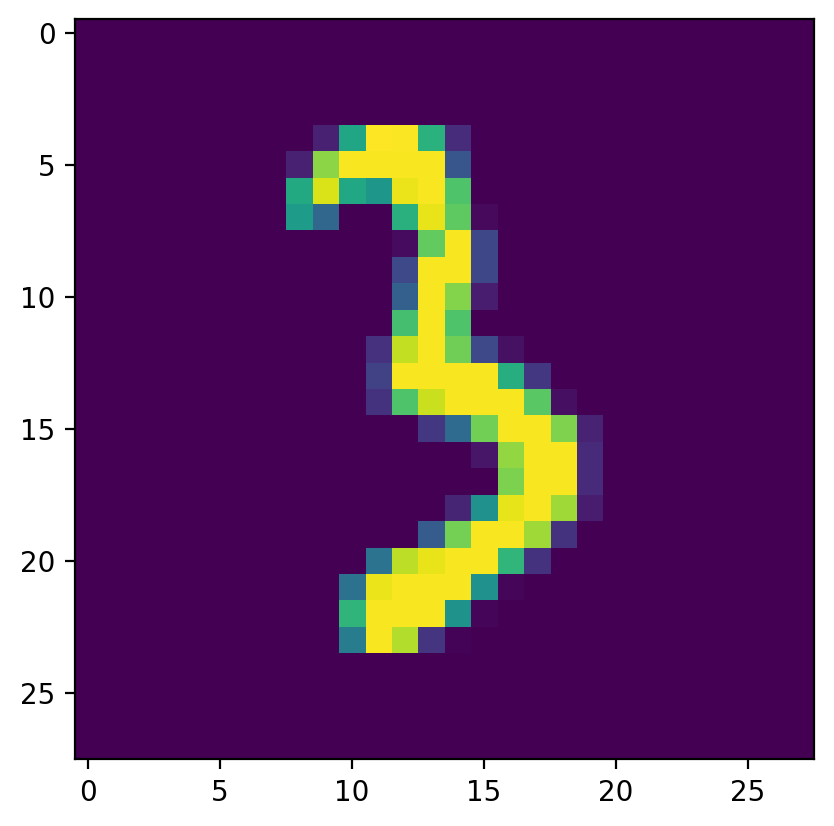

In [ ]:
sample = 44
print(targets[sample])
plt.imshow(features[sample].reshape(28, 28));

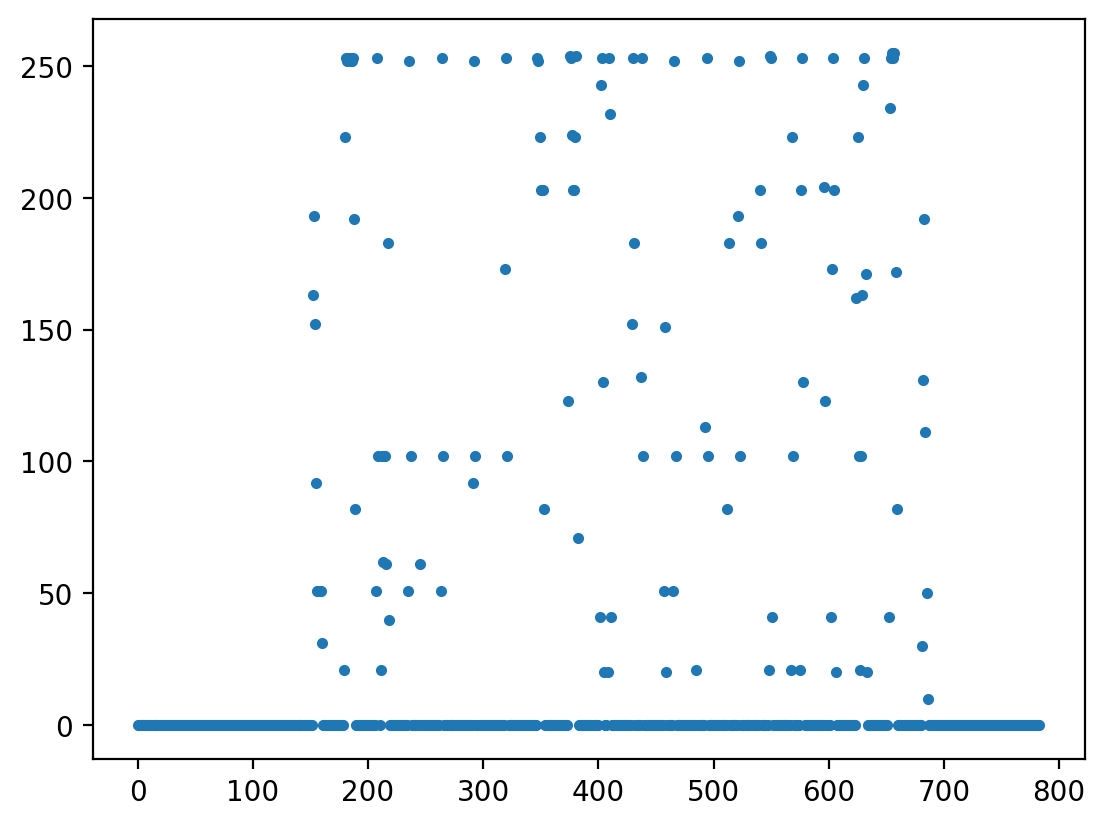

In [ ]:
plt.plot(features[45], ".");

In [ ]:
features = (features - jnp.mean(features))
features = features / jnp.max(jnp.abs(features))

3


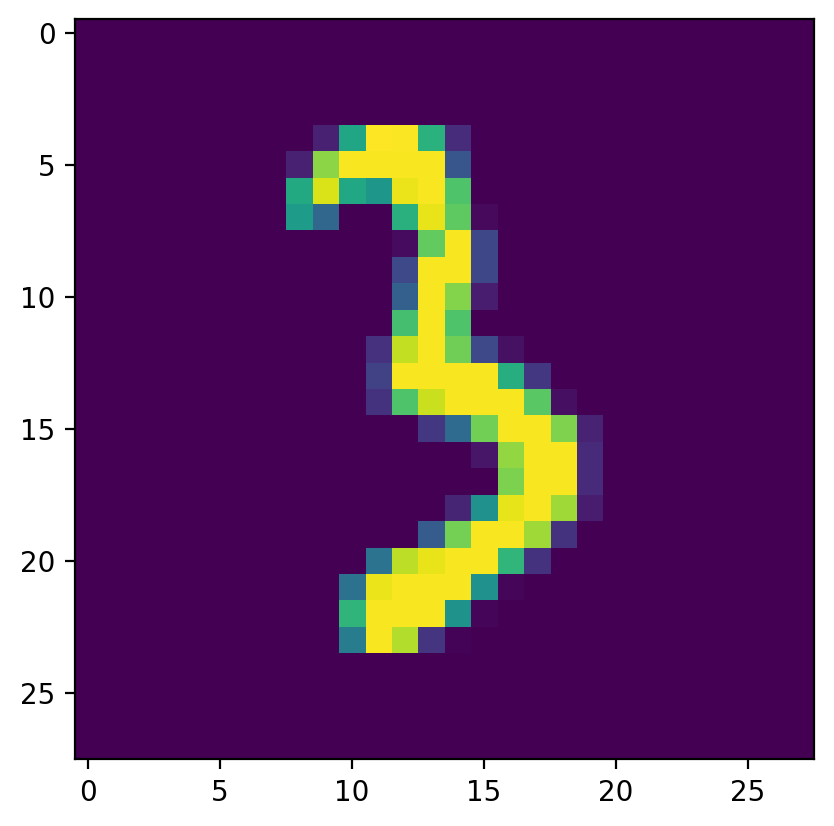

In [ ]:
sample = 44
print(targets[sample])
plt.imshow(features[sample].reshape(28, 28));

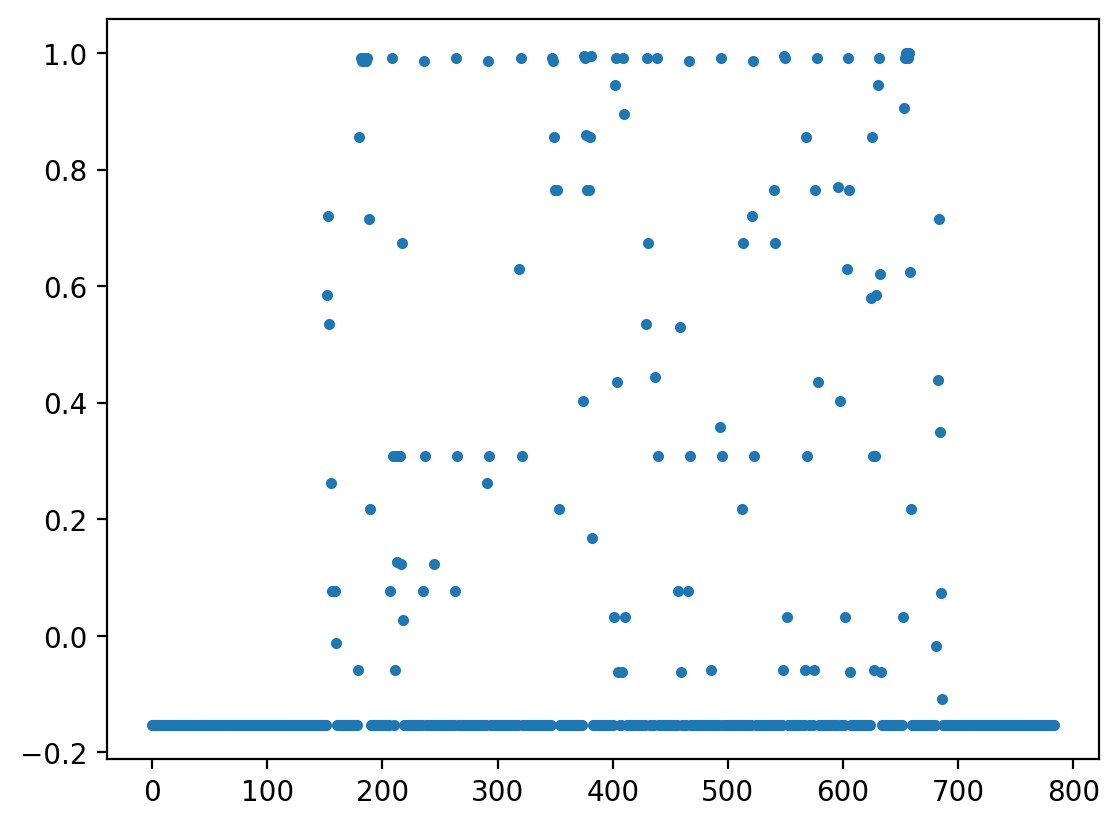

In [ ]:
plt.plot(features[45], ".");

# Feedforward neural network = MLP

$$
x_0 = \text{input}
$$

$$
x_{i+1} = \sigma\left(W_i x_{i} + b_i\right)
$$

$$
x_{N} = \exp(x_{N-1}) \big / \sum_i \exp(\left(x_{N-1}\right)_{i}) \in [0, 1]^{N_{\text{clasese}}}
$$

$$
\sum_{c}\left(x_{N}\right)_{c}(W_{1}, b_{1}, \dots, W_{N-1}, b_{N-1},) \rightarrow \max
$$

$$
\frac{1}{N_{\text{batch}}}\sum_{c\in\text{batch}}\left(x_{N}\right)_{c}(W_{1}, b_{1}, \dots, W_{N-1}, b_{N-1},) \rightarrow \max
$$

$$
\frac{1}{N_{\text{batch}}}\sum_{c\in\text{batch}}-\log\left(x_{N}\right)_{c}(W_{1}, b_{1}, \dots, W_{N-1}, b_{N-1},) \rightarrow \min
$$

$$
W_i \leftarrow W_i - \eta \nabla_{W_i} L
$$

# MLP

In [ ]:
train_features = features[:5000]
test_features = features[5000:]

train_targets = targets[:5000]
test_targets = targets[5000:]

In [ ]:
shapes = [train_features.shape[1], 111, 123, 114, 56, 10]
key = random.PRNGKey(12)
keys = random.split(key, len(shapes)-1)
weights = [random.normal(key, (s_out, s_in)) / jnp.sqrt(s_out/2 + s_in/2) for s_in, s_out, key in zip(shapes[:-1], shapes[1:], keys)]
biases = [jnp.zeros((s,)) for s in shapes[1:]]

In [ ]:
len(weights), len(biases)

(5, 5)

In [ ]:
for i in range(len(shapes)-1):
    print(weights[i].shape, biases[i].shape)

(111, 784) (111,)
(123, 111) (123,)
(114, 123) (114,)
(56, 114) (56,)
(10, 56) (10,)


In [ ]:
sample = 66
s = train_features[sample]
print(s.shape)
for i in range(len(shapes)-1):
    s = relu(weights[i] @ s + biases[i])
    print(s.shape)
#softmax сами расписали
s_max = jnp.max(s)
s_ = jnp.exp(s - s_max)
s1 = s_ / jnp.sum(s_, keepdims=True)
print(s1)

s = softmax(s)
print(s)
print(jnp.sum(s))

(784,)
(111,)
(123,)
(114,)
(56,)
(10,)
[2.3926564e-03 1.2465598e-13 3.5119556e-02 1.4209558e-11 9.6232986e-01
 1.3543531e-11 8.7057419e-09 1.2465598e-13 1.5794137e-04 1.2465598e-13]
[2.3926564e-03 1.2465598e-13 3.5119556e-02 1.4209558e-11 9.6232986e-01
 1.3543531e-11 8.7057419e-09 1.2465598e-13 1.5794137e-04 1.2465598e-13]
1.0


In [ ]:
params = [weights, biases]

In [ ]:
def call_model(params, feature):
    weights, biases = params
    s = weights[0] @ feature + biases[0]
    # print(s.shape)
    for w, b in zip(weights[1:], biases[1:]):
        s = relu(s)
        s = w @ s + b
        # print(s.shape)
    s = softmax(s)
    return s

In [ ]:
call_model(params, train_features[11])

Array([2.1460220e-20, 2.5792847e-24, 7.6345760e-13, 1.7871916e-11,
       3.0593978e-02, 1.7935744e-20, 1.3155779e-15, 1.4819197e-27,
       9.6940607e-01, 3.0008420e-22], dtype=float32)

In [ ]:
def loss(params, feature, target):
    probabilities = call_model(params, feature)
    return -probabilities[target]

In [ ]:
for sample in [445, 221, 116, 224]:
  print( train_targets[sample])
  print(loss(params, train_features[sample], train_targets[sample]))

6
-0.956492
2
-0.99999976
4
-3.3374015e-06
1
-1.0921616e-08


In [ ]:
d_loss = grad(loss)

In [ ]:
sample = 445
d_params = d_loss(params, train_features[sample], train_targets[sample])

In [ ]:
for w, b in zip(*params):
    print(w.shape, b.shape)

(111, 784) (111,)
(123, 111) (123,)
(114, 123) (114,)
(56, 114) (56,)
(10, 56) (10,)


In [ ]:
for d_w, d_b in zip(*d_params):
    print(d_w.shape, d_b.shape)

(111, 784) (111,)
(123, 111) (123,)
(114, 123) (114,)
(56, 114) (56,)
(10, 56) (10,)


In [ ]:
def update_weights(params, feature, target, eta):
  d_params = d_loss(params, feature, target)
  for i in range(len(params[0])):
      params[0][i] -= d_params[0][i]*eta
      params[1][i] -= d_params[1][i]*eta
  return params

In [ ]:
eta = 1e-4
sample = 667
params_ = update_weights(params, train_features[sample], train_targets[sample], eta)
for w, b in zip(*params_):
    print(w.shape, b.shape)

(111, 784) (111,)
(123, 111) (123,)
(114, 123) (114,)
(56, 114) (56,)
(10, 56) (10,)


In [ ]:
N_rounds = 1000
key = random.PRNGKey(33)
inds = random.randint(key, minval=0, maxval=train_features.shape[0], shape=(N_rounds, 2))
losses = []
for ind in inds:
    start = time.time()
    params = update_weights(params, train_features[ind[0]], train_targets[ind[0]], eta)
    stop = time.time()
    #print(stop - start)
    loss_ = loss(params, test_features[ind[1]], test_targets[ind[1]])
    losses.append(loss_)

In [ ]:
len(losses)

1000

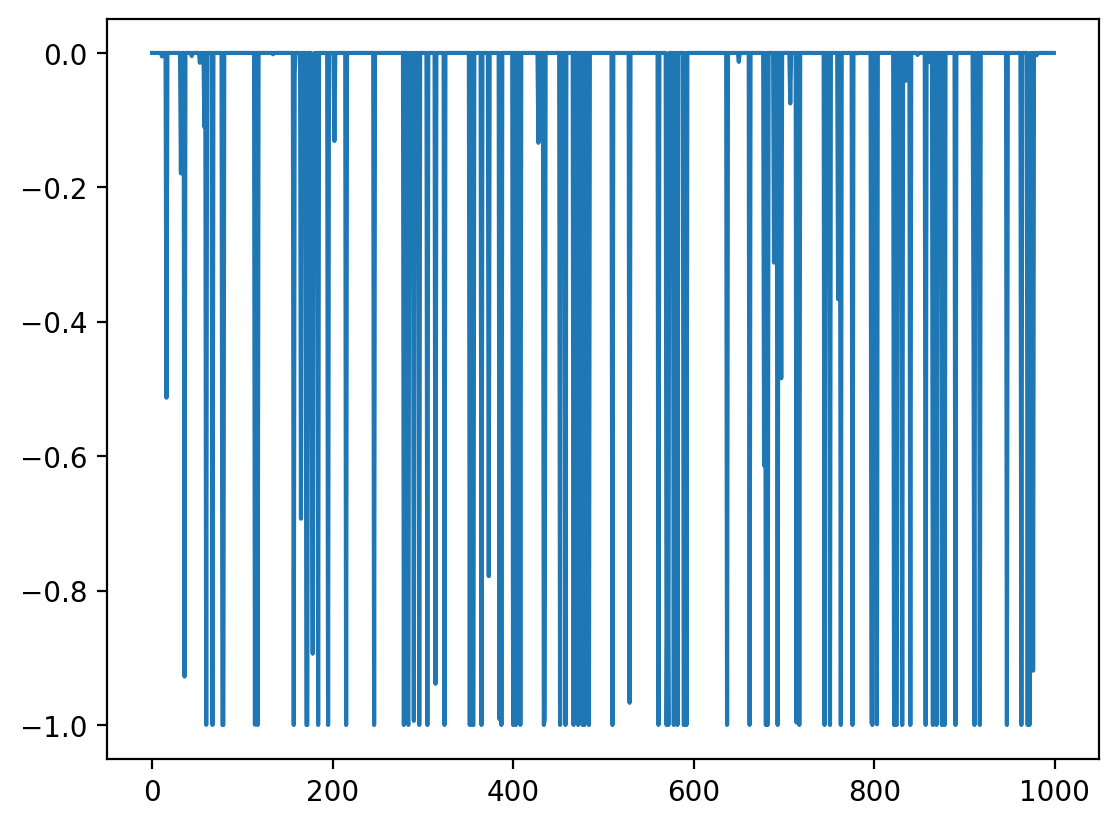

In [ ]:
plt.plot(losses)

In [ ]:
def loss(params, feature, target):
    probabilities = call_model(params, feature)
    return -probabilities[target]

def batch_loss(params, features, targets):
    return jnp.mean(vmap(loss, in_axes=(None, 0, 0))(params, features, targets))

def batch_loss_no_vmap(params, features, targets):
    n = features.shape[0]
    R = []
    for i in range(n):
        res = loss(params, features[i], targets[i])
        R.append(res)
    R = jnp.array(R)
    return jnp.mean(R)

In [ ]:
def f(x, y):
    return x*y

In [ ]:
vmap_f = vmap(f, in_axes=(0, 0))

In [ ]:
x = jnp.array([1.0, ])
y = jnp.array([2.0, ])

f(x, y)

Array([2.], dtype=float32)

In [ ]:
x = jnp.array([1.0, 2.3, 4.5])
y = jnp.array([2.0, 4.1, 5.1])

vmap_f(x, y)

Array([ 2.      ,  9.429999, 22.949999], dtype=float32)

In [ ]:
for i in range(x.shape[0]):
  print(f(x[i], y[i]))

2.0
9.429999
22.949999


In [ ]:
for i in range(10):
  print(loss(params, train_features[i], train_targets[i]))

-2.0259467e-33
-0.0
-2.731038e-23
-0.0
-4.1584066e-20
-2.6549854e-28
-6.2078587e-38
-3.713468e-22
-2.7673385e-17
-9.082175e-18


In [ ]:
def batch_loss_(params, features, targets):
    return vmap(loss, in_axes=(None, 0, 0))(params, features, targets)

In [ ]:
batch_loss_(params, train_features[:10], train_targets[:10])

Array([-1.94777430e-33, -0.00000000e+00, -2.53627948e-23, -0.00000000e+00,
       -3.16145910e-20, -2.51311661e-28, -4.14282092e-38, -3.87400629e-22,
       -2.43161818e-17, -1.35234815e-17], dtype=float32)

In [ ]:
def update_weights_batch(params, features, targets, eta):
  d_params = grad(batch_loss)(params, features, targets)
  for i in range(len(params[0])):
      params[0][i] -= d_params[0][i]*eta
      params[1][i] -= d_params[1][i]*eta
  return params

In [ ]:
eta = 1e-4
sample = 667
params_ = update_weights_batch(params, train_features[:10], train_targets[:10], eta)
for w, b in zip(*params_):
    print(w.shape, b.shape)

(111, 784) (111,)
(123, 111) (123,)
(114, 123) (114,)
(56, 114) (56,)
(10, 56) (10,)


In [ ]:
N_rounds = 500
N_batch = 10
key = random.PRNGKey(33)
inds = random.randint(key, minval=0, maxval=train_features.shape[0], shape=(N_rounds, 2, N_batch))
losses = []
for ind in inds:
    start = time.time()
    params = update_weights_batch(params, train_features[ind[0]], train_targets[ind[0]], eta)
    stop = time.time()
    #print(stop - start)
    loss_ = batch_loss(params, test_features[ind[1]], test_targets[ind[1]])
    losses.append(loss_)

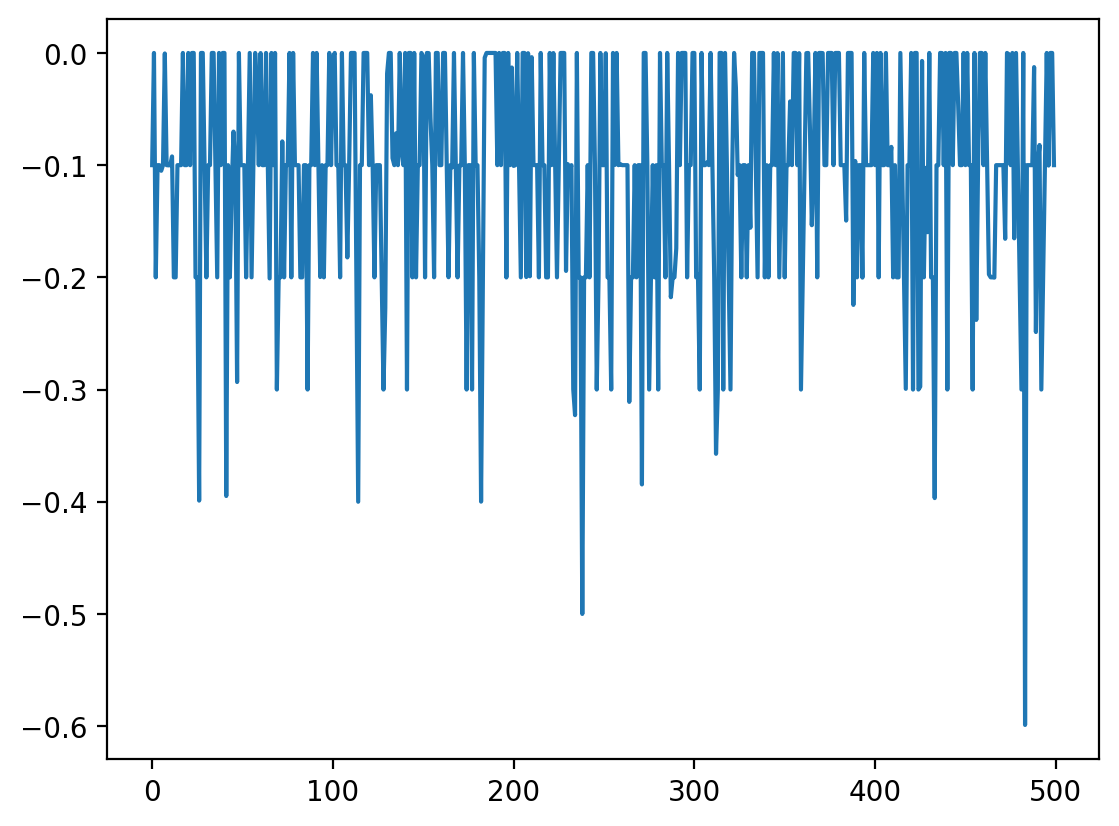

In [ ]:
plt.plot(losses)

In [ ]:
update_weights_batch_jitted = jit(update_weights_batch)

In [ ]:
N_rounds = 10
N_batch = 10
key = random.PRNGKey(33)
inds = random.randint(key, minval=0, maxval=train_features.shape[0], shape=(N_rounds, 2, N_batch))
losses = []
for ind in inds:
    start = time.time()
    params = update_weights_batch(params, train_features[ind[0]], train_targets[ind[0]], eta)
    stop = time.time()
    print(stop - start)
    loss_ = batch_loss(params, test_features[ind[1]], test_targets[ind[1]])
    losses.append(loss_)

0.03558969497680664
0.033995628356933594
0.03485751152038574
0.03214550018310547
0.0322568416595459
0.03331184387207031
0.03163743019104004
0.031676530838012695
0.03176426887512207
0.03250575065612793


In [ ]:
N_rounds = 10
N_batch = 10
key = random.PRNGKey(33)
inds = random.randint(key, minval=0, maxval=train_features.shape[0], shape=(N_rounds, 2, N_batch))
losses = []
for ind in inds:
    start = time.time()
    params = update_weights_batch_jitted(params, train_features[ind[0]], train_targets[ind[0]], eta)
    stop = time.time()
    print(stop - start)
    loss_ = batch_loss(params, test_features[ind[1]], test_targets[ind[1]])
    losses.append(loss_)

0.2493293285369873
0.0026960372924804688
0.0025911331176757812
0.002778768539428711
0.0025255680084228516
0.002470254898071289
0.0028035640716552734
0.002822399139404297
0.002726316452026367
0.002815723419189453


In [ ]:
N_rounds = 1000
N_batch = 10
key = random.PRNGKey(33)
inds = random.randint(key, minval=0, maxval=train_features.shape[0], shape=(N_rounds, 2, N_batch))
losses = []
for ind in inds:
    start = time.time()
    params = update_weights_batch_jitted(params, train_features[ind[0]], train_targets[ind[0]], eta)
    stop = time.time()
    #print(stop - start)
    loss_ = batch_loss(params, test_features[ind[1]], test_targets[ind[1]])
    losses.append(loss_)

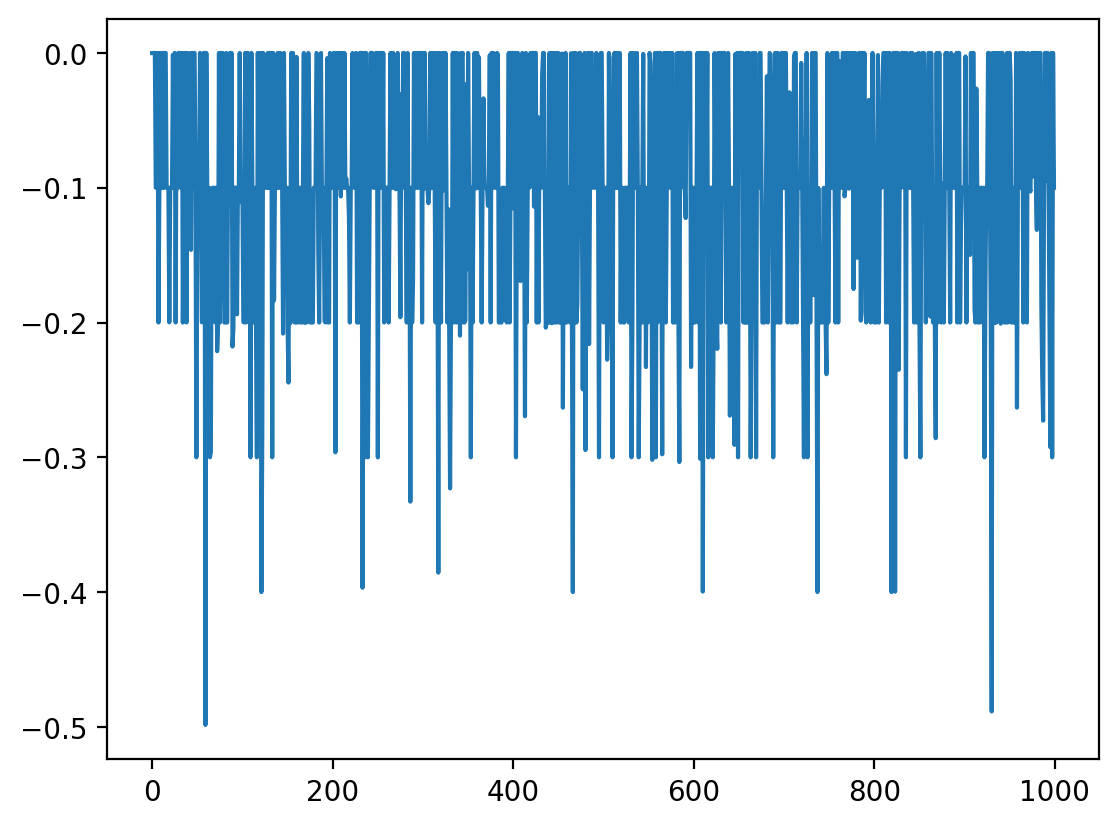

In [ ]:
plt.plot(losses)

# MLP clean

In [ ]:
train_features = features[:5000]
test_features = features[5000:]

train_targets = targets[:5000]
test_targets = targets[5000:]

In [ ]:
def call_model(params, feature):
    weights, biases = params
    s = weights[0] @ feature + biases[0]
    # print(s.shape)
    for w, b in zip(weights[1:], biases[1:]):
        s = relu(s)
        s = w @ s + b
        # print(s.shape)
    s = log_softmax(s)
    return s

def loss(params, feature, target):
    log_prob = call_model(params, feature)
    return -log_prob[target]

def batch_loss(params, features, targets):
    return jnp.mean(vmap(loss, in_axes=(None, 0, 0))(params, features, targets))

@jit
def update_weights_batch(params, features, targets, eta):
  d_params = grad(batch_loss)(params, features, targets)
  for i in range(len(params[0])):
      params[0][i] -= d_params[0][i]*eta
      params[1][i] -= d_params[1][i]*eta
  return params

In [ ]:
shapes = [train_features.shape[1],]*3 + [10,]
key = random.PRNGKey(12)
keys = random.split(key, len(shapes)-1)
weights = [random.normal(key, (s_out, s_in)) / jnp.sqrt(s_out/2 + s_in/2) for s_in, s_out, key in zip(shapes[:-1], shapes[1:], keys)]
biases = [jnp.zeros((s,)) for s in shapes[1:]]
params = [weights, biases]
print(shapes)

[784, 784, 784, 10]


In [ ]:
prediction_test = jnp.argmax(vmap(call_model, in_axes=(None, 0))(params, test_features), axis=1)
test_acc = jnp.mean(test_targets == prediction_test).item()

prediction_train = jnp.argmax(vmap(call_model, in_axes=(None, 0))(params, train_features), axis=1)
train_acc = jnp.mean(train_targets == prediction_train).item()

print(test_acc, train_acc)

0.085999995470047 0.09239999949932098


In [ ]:
N_rounds = 1000
N_batch = 64
eta = 1e-3
key = random.PRNGKey(33)
inds = random.randint(key, minval=0, maxval=train_features.shape[0], shape=(N_rounds, 2, N_batch))

accs = []
L = []
for ind in tqdm(inds):
    start = time.time()
    params = update_weights_batch(params, train_features[ind[0]], train_targets[ind[0]], eta)
    loss_ = batch_loss(params, train_features[ind[0]], train_targets[ind[0]])
    stop = time.time()
    L.append(loss_)
    prediction = jnp.argmax(vmap(call_model, in_axes=(None, 0))(params, test_features[ind[1]]), axis=1)
    acc = jnp.mean(test_targets[ind[1]] == prediction)
    accs.append(acc)

100%|██████████| 1000/1000 [00:25<00:00, 38.86it/s]


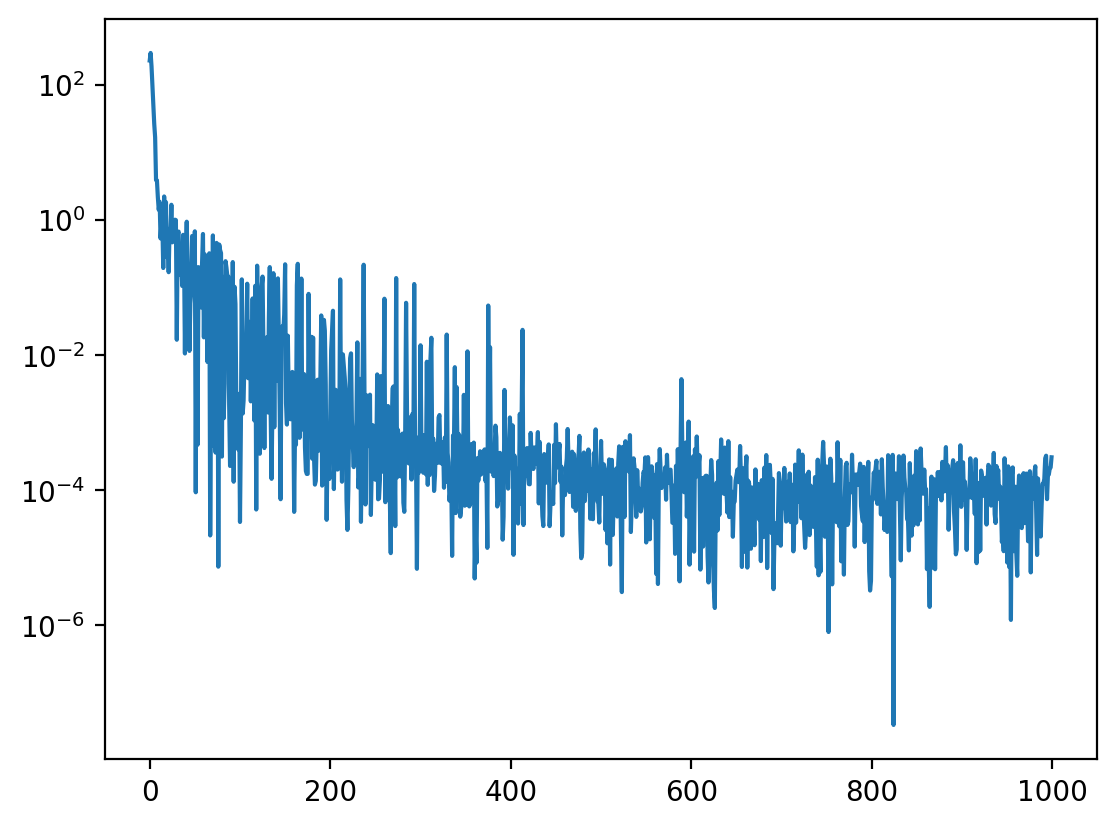

In [ ]:
plt.yscale("log")
plt.plot(L);

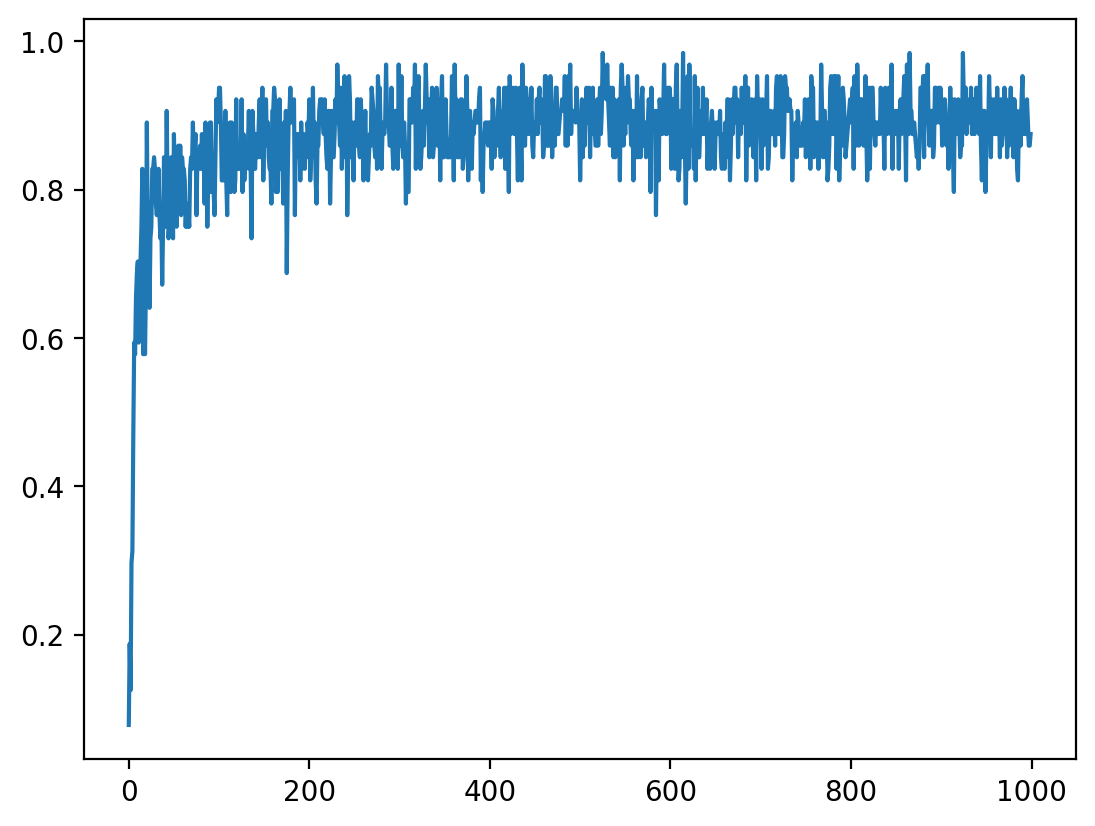

In [ ]:
plt.plot(accs);

In [ ]:
prediction_test = jnp.argmax(vmap(call_model, in_axes=(None, 0))(params, test_features), axis=1)
test_acc = jnp.mean(test_targets == prediction_test).item()

prediction_train = jnp.argmax(vmap(call_model, in_axes=(None, 0))(params, train_features), axis=1)
train_acc = jnp.mean(train_targets == prediction_train).item()

print(test_acc, train_acc)

0.8953999876976013 0.9997999668121338


# MLP + optax

In [ ]:
! pip install -q --no-deps equinox diffrax jaxtyping lineax optimistix wadler-lindig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 4.4 MB/s eta 0:00:00


In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import itertools
import equinox as eqx
import optax
import diffrax
import time

from jax import grad, random, config, vmap, jit
from jax.lax import scan, dot_general
from jax.nn import relu, gelu, sigmoid, softmax, log_softmax
from jax.tree_util import tree_map, tree_flatten
from numpy import genfromtxt

from tqdm import tqdm

%config InlineBackend.figure_format='retina'

In [ ]:
my_data = genfromtxt('/content/sample_data/mnist_test.csv', delimiter=',')
features = jnp.array(my_data[:, 1:])
targets = jnp.array(my_data[:, 0]).astype(int)
features.shape, targets.shape

((10000, 784), (10000,))

In [ ]:
features = (features - jnp.mean(features))
features = features / jnp.max(jnp.abs(features))

In [ ]:
train_features = features[:5000]
test_features = features[5000:]

train_targets = targets[:5000]
test_targets = targets[5000:]

In [ ]:
def call_model(params, feature):
    weights, biases = params
    s = weights[0] @ feature + biases[0]
    # print(s.shape)
    for w, b in zip(weights[1:], biases[1:]):
        s = relu(s)
        s = w @ s + b
        # print(s.shape)
    s = log_softmax(s)
    return s

def loss(params, feature, target):
    log_prob = call_model(params, feature)
    return -log_prob[target]

def batch_loss(params, features, targets):
    return jnp.mean(vmap(loss, in_axes=(None, 0, 0))(params, features, targets))

@jit
def update_weights_batch(params, features, targets, eta):
  d_params = grad(batch_loss)(params, features, targets)
  for i in range(len(params[0])):
      params[0][i] -= d_params[0][i]*eta
      params[1][i] -= d_params[1][i]*eta
  return params

@jit
def update_weights_batch_optax(params, features, targets, eta):
  optimizer = optax.adam(eta)
  # optimizer = optax.lion(eta)
  # optimizer = optax.adamw(eta)
  opt_state = optimizer.init(params)
  grads = grad(batch_loss)(params, features, targets)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  # print('something')
  return params

In [ ]:
shapes = [train_features.shape[1],]*3 + [10,]
key = random.PRNGKey(12)
keys = random.split(key, len(shapes)-1)
weights = [random.normal(key, (s_out, s_in)) / jnp.sqrt(s_out/2 + s_in/2) for s_in, s_out, key in zip(shapes[:-1], shapes[1:], keys)]
biases = [jnp.zeros((s,)) for s in shapes[1:]]
params = [weights, biases]

In [ ]:
prediction_test = jnp.argmax(vmap(call_model, in_axes=(None, 0))(params, test_features), axis=1)
test_acc = jnp.mean(test_targets == prediction_test).item()

prediction_train = jnp.argmax(vmap(call_model, in_axes=(None, 0))(params, train_features), axis=1)
train_acc = jnp.mean(train_targets == prediction_train).item()

print(test_acc, train_acc)

0.0803999975323677 0.09259999543428421


In [ ]:
N_rounds = 1000
N_batch = 64
eta = 1e-3
key = random.PRNGKey(33)
inds = random.randint(key, minval=0, maxval=train_features.shape[0], shape=(N_rounds, 2, N_batch))

accs = []
L = []
for ind in tqdm(inds):
    start = time.time()
    params = update_weights_batch_optax(params, train_features[ind[0]], train_targets[ind[0]], eta)
    loss_ = batch_loss(params, train_features[ind[0]], train_targets[ind[0]])
    stop = time.time()
    L.append(loss_)
    prediction = jnp.argmax(vmap(call_model, in_axes=(None, 0))(params, test_features[ind[1]]), axis=1)
    acc = jnp.mean(test_targets[ind[1]] == prediction)
    accs.append(acc)

100%|██████████| 1000/1000 [00:26<00:00, 37.82it/s]


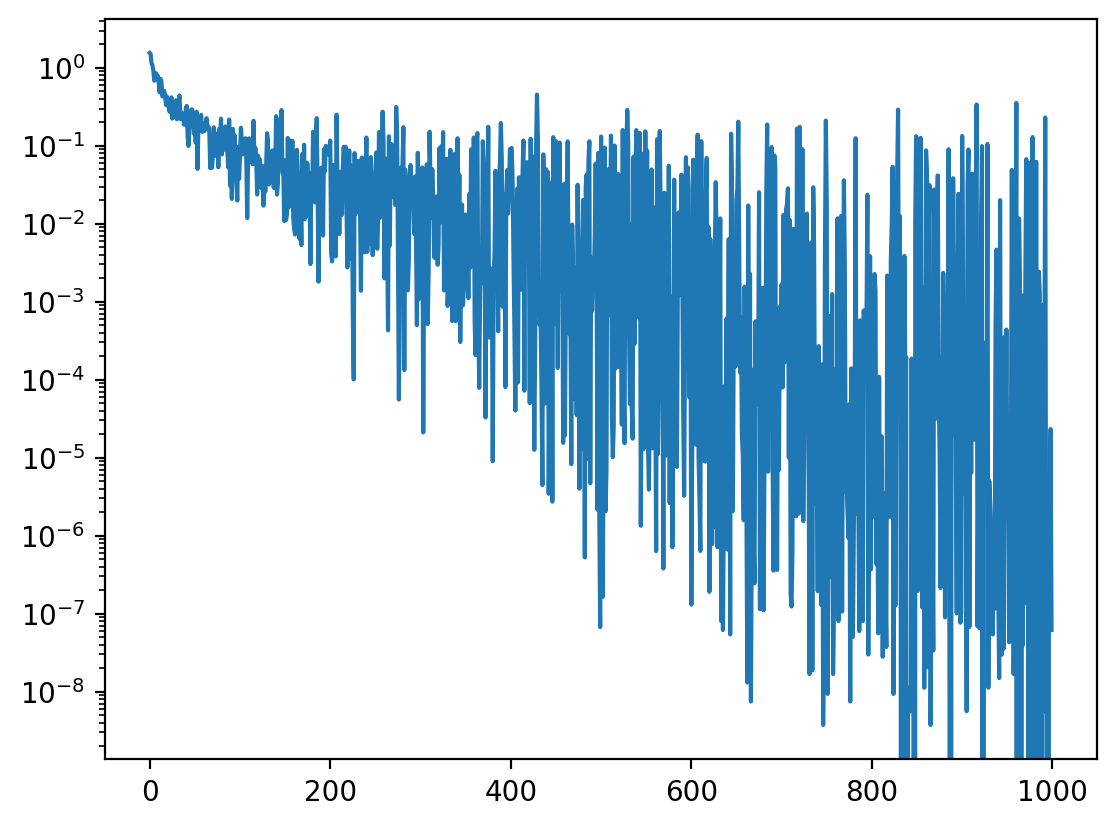

In [ ]:
plt.yscale("log")
plt.plot(L);

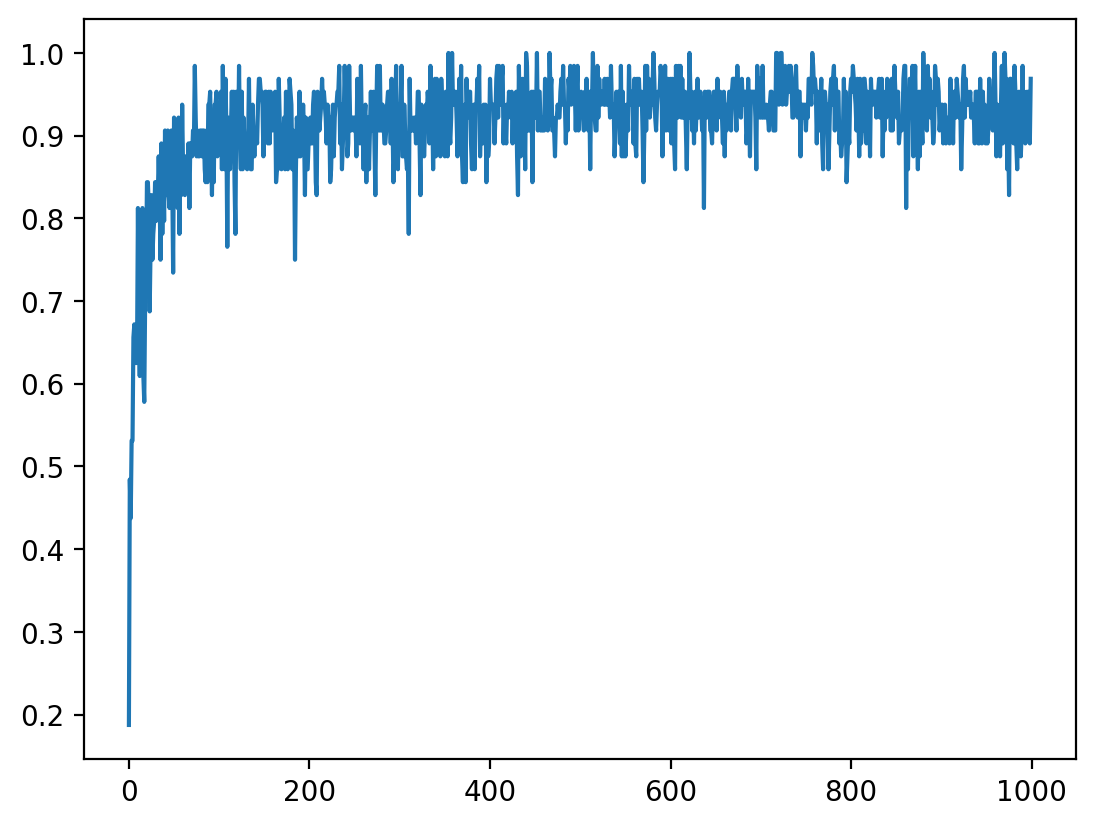

In [ ]:
plt.plot(accs);

In [ ]:
prediction = jnp.argmax(vmap(call_model, in_axes=(None, 0))(params, test_features), axis=1)
acc = jnp.mean(test_targets == prediction)
print("final accuracy", acc)

final accuracy 0.9442


In [ ]:
def update_weights_batch_optax(params, features, targets, optimizer, opt_state):
  grads = grad(batch_loss)(params, features, targets)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  # print('something')
  return params, opt_state

update_weights_batch_optax = jit(update_weights_batch_optax, static_argnums=3)

In [ ]:
shapes = [train_features.shape[1],]*3 + [10,]
key = random.PRNGKey(12)
keys = random.split(key, len(shapes)-1)
weights = [random.normal(key, (s_out, s_in)) / jnp.sqrt(s_out/2 + s_in/2) for s_in, s_out, key in zip(shapes[:-1], shapes[1:], keys)]
biases = [jnp.zeros((s,)) for s in shapes[1:]]
params = [weights, biases]

eta = 1e-3
optimizer = optax.adam(eta)
opt_state = optimizer.init(params)

In [ ]:
N_rounds = 1000
N_batch = 64
eta = 1e-3
key = random.PRNGKey(44)
inds = random.randint(key, minval=0, maxval=train_features.shape[0], shape=(N_rounds, 2, N_batch))

accs = []
L = []
for ind in tqdm(inds):
    start = time.time()
    params, opt_state = update_weights_batch_optax(params, train_features[ind[0]], train_targets[ind[0]], optimizer, opt_state)
    loss_ = batch_loss(params, train_features[ind[0]], train_targets[ind[0]])
    stop = time.time()
    L.append(loss_)
    prediction = jnp.argmax(vmap(call_model, in_axes=(None, 0))(params, test_features[ind[1]]), axis=1)
    acc = jnp.mean(test_targets[ind[1]] == prediction)
    accs.append(acc)

100%|██████████| 1000/1000 [00:24<00:00, 40.29it/s]


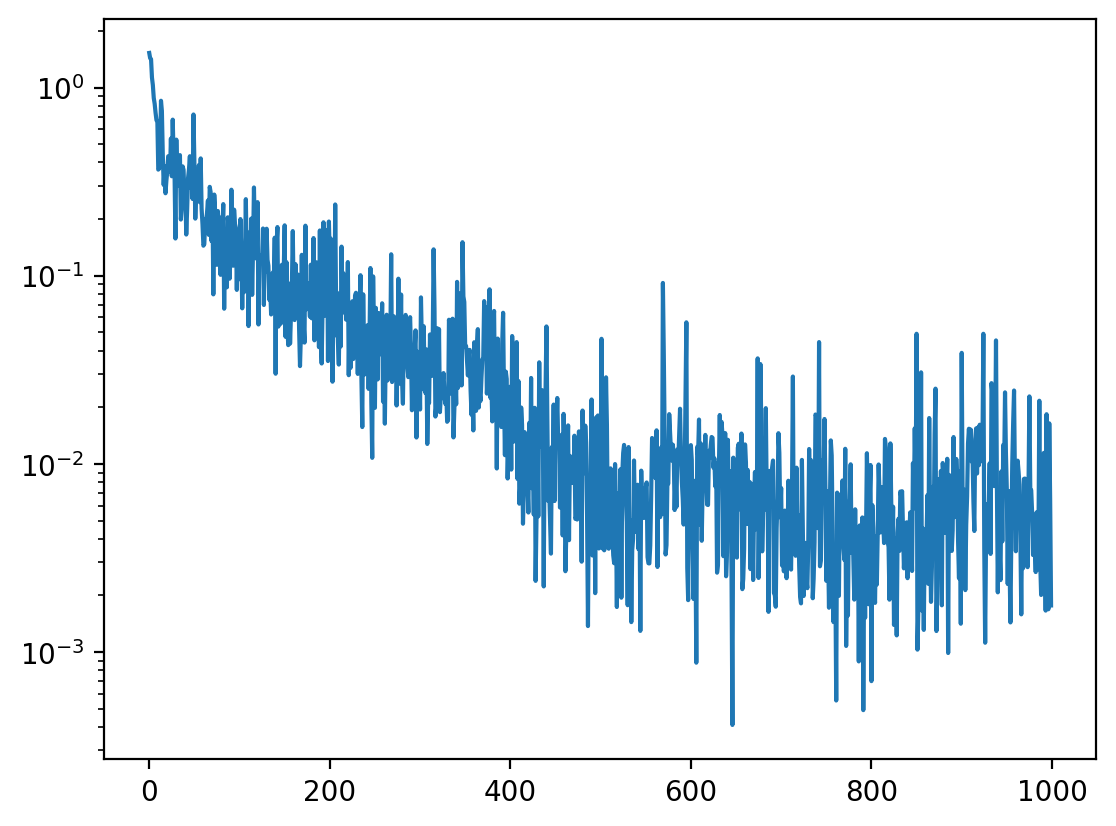

In [ ]:
plt.yscale("log")
plt.plot(L);

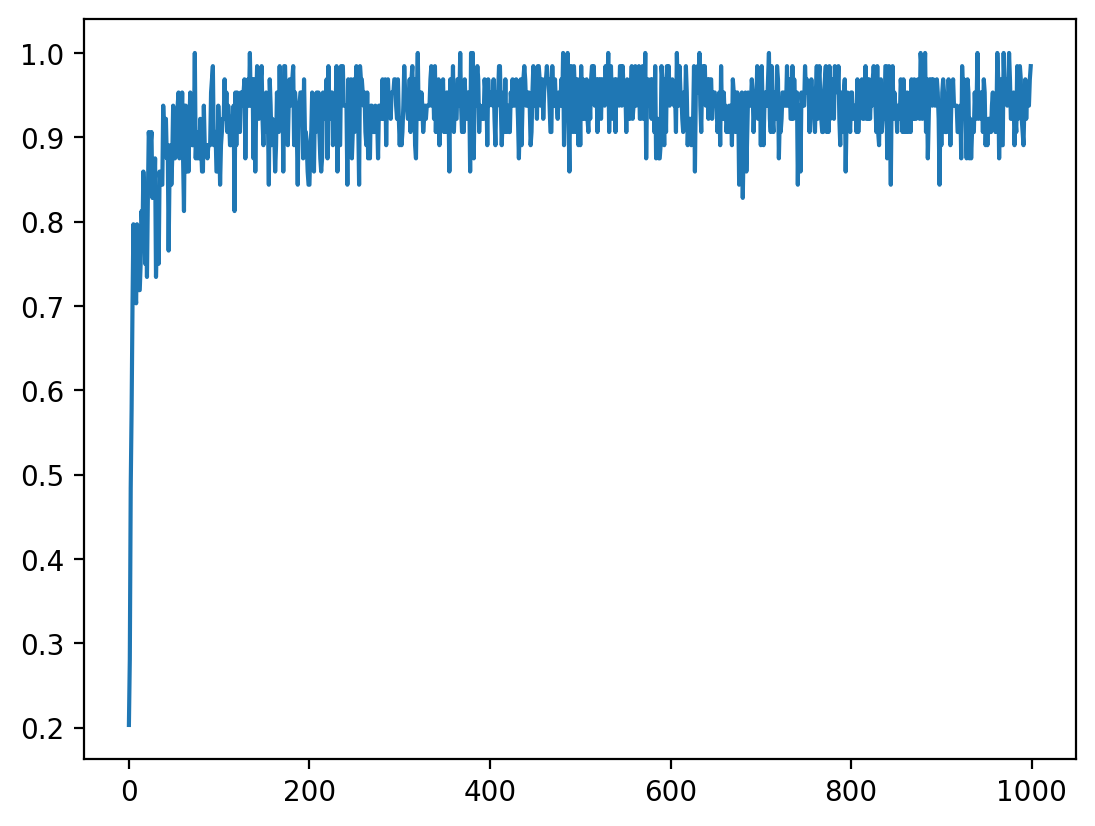

In [ ]:
plt.plot(accs);

In [ ]:
prediction = jnp.argmax(vmap(call_model, in_axes=(None, 0))(params, test_features), axis=1)
acc = jnp.mean(test_targets == prediction)
print("final accuracy", acc)

final accuracy 0.9428


# MLP + equinox

In [ ]:
! pip install -q --no-deps equinox diffrax jaxtyping lineax optimistix wadler-lindig

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import itertools
import equinox as eqx
import optax
import diffrax
import time

from jax import grad, random, config, vmap, jit
from jax.lax import scan, dot_general
from jax.nn import relu, gelu, sigmoid, softmax, log_softmax
from jax.tree_util import tree_map, tree_flatten
from numpy import genfromtxt

from tqdm import tqdm

%config InlineBackend.figure_format='retina'

In [ ]:
class MLP(eqx.Module):
    linear1: eqx.nn.Linear
    linear2: eqx.nn.Linear
    linear3: eqx.nn.Linear

    def __init__(self, key):
        key1, key2, key3 = random.split(key, 3)
        self.linear1 = eqx.nn.Linear(in_features=28*28, out_features=256, key=key1)
        self.linear2 = eqx.nn.Linear(in_features=256, out_features=128, key=key2)
        self.linear3 = eqx.nn.Linear(in_features=128, out_features=10, key=key3)

    def __call__(self, x):
        #x = x.reshape(x.shape[0], -1)
        x = relu(self.linear1(x))
        x = relu(self.linear2(x))
        x = self.linear3(x)
        x = log_softmax(x)
        return x

def loss_fn(model, x, y):
    logits = model(x)
    return -logits[y]

def batch_loss(model, x, y):
    return jnp.mean(vmap(loss_fn, in_axes=(None, 0, 0))(model, x, y))

def accuracy(model, x, y):
    logits = model(x)
    return jnp.argmax(logits) == y

def update(model, x, y, opt_state, optimizer):
    loss, grads = eqx.filter_value_and_grad(batch_loss)(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

def load_data(batch_size):
    my_data = genfromtxt('/content/sample_data/mnist_test.csv', delimiter=',')
    features = jnp.array(my_data[:, 1:], dtype=jnp.float32) / 255.0
    targets = jnp.array(my_data[:, 0], dtype=jnp.int32)

    num_samples = features.shape[0]
    num_batches = num_samples // batch_size

    features = features[: num_batches * batch_size].reshape(num_batches, batch_size, -1)
    targets = targets[: num_batches * batch_size].reshape(num_batches, batch_size)

    return list(zip(features, targets))

def train(epochs=1000, learning_rate=1e-3, batch_size=64):
    key = random.PRNGKey(0)
    model = MLP(key)
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    data_batches = load_data(batch_size)

    for epoch in range(epochs):
        for x, y in data_batches:
            model, opt_state, loss = update(model, x, y, opt_state, optimizer)
        acc = jnp.mean(vmap(accuracy, in_axes=(None, 0, 0))(model, x, y))
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

In [ ]:
learning_rate=1e-3
batch_size=64
data_batches = load_data(batch_size)
i = 0
epochs = 200

key = random.PRNGKey(0)
model = MLP(key)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
data_batches = load_data(batch_size)

for epoch in range(epochs):
    for x, y in data_batches:
        model, opt_state, loss = update(model, x, y, opt_state, optimizer)
    acc = jnp.mean(vmap(accuracy, in_axes=(None, 0, 0))(model, x, y))
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

Epoch 1, Loss: 0.5135, Accuracy: 0.8750
Epoch 2, Loss: 0.3554, Accuracy: 0.9062
Epoch 3, Loss: 0.2610, Accuracy: 0.9375
Epoch 4, Loss: 0.2156, Accuracy: 0.9375
Epoch 5, Loss: 0.1528, Accuracy: 0.9531
Epoch 6, Loss: 0.1032, Accuracy: 0.9844
Epoch 7, Loss: 0.0824, Accuracy: 0.9844
Epoch 8, Loss: 0.0531, Accuracy: 1.0000
Epoch 9, Loss: 0.0363, Accuracy: 1.0000
Epoch 10, Loss: 0.0213, Accuracy: 1.0000
Epoch 11, Loss: 0.0354, Accuracy: 1.0000


KeyboardInterrupt: 

# Hopfield + optax + equinox

$$
\dot{x} = W \nabla L(x) - x + b
$$

$$
E(x) = (x - b)^{\top} g(x) - L(x) - \frac{1}{2} \nabla L(x)^\top W \nabla L(x) \Rightarrow \dot{E}(x) = \left(E^{'}\right)^\top \dot{x} = \left(E^{'}\right)^\top \left(W \nabla L(x) - x + b\right) \leq 0
$$

$$
x(t=0) = \text{input}
$$

$$
x_{N-1} = x(T)_{-10:}
$$

$$
x_{N} = \exp(x_{N-1}) \big / \sum_i \exp(\left(x_{N-1}\right)_{i}) \in [0, 1]^{N_{\text{clasese}}}
$$

$$
\sum_{c}\left(x_{N}\right)_{c}(W, b) \rightarrow \max
$$

$$
\frac{1}{N_{\text{batch}}}\sum_{c\in\text{batch}}\left(x_{N}\right)_{c}(W, b) \rightarrow \max
$$

$$
\frac{1}{N_{\text{batch}}}\sum_{c\in\text{batch}}-\log\left(x_{N}\right)_{c}(W, b) \rightarrow \min
$$

$$
W \leftarrow W - \eta \nabla_{W} L
$$

In [ ]:
class Hopfield(eqx.Module):
    W: jnp.array
    b: jnp.array

    def __init__(self, N_neurons, key):
        self.W = random.normal(key, (N_neurons, N_neurons)) / jnp.sqrt(N_neurons)
        self.b = jnp.zeros((N_neurons, ))

    def __call__(self, x):
        return (self.W + self.W.T) @ relu(x) / 2 - x + self.b

    def energy(self, x):
        r = relu(x)
        E = (x - self.b) @ r - jnp.sum(r**2) / 2 - r @ (self.W + self.W.T) @ r / 4
        return E

$$
\frac{x(t+\Delta t) - x(t)}{\Delta t} = f(x, t) \Leftrightarrow \dot{x} = f(x, t)
$$

In [ ]:
def integrate(model, x, dt, N_steps):
    for _ in range(N_steps):
        x = x + dt*model(x)
    return x

def loss_fn(model, x, y, dt, N_steps, N_classes):
    x_T = integrate(model, x, dt, N_steps)[-N_classes:]
    logits = log_softmax(x_T)
    return -logits[y]

def batch_loss(model, x, y, dt, N_steps, N_classes):
    return jnp.mean(vmap(loss_fn, in_axes=(None, 0, 0, None, None, None))(model, x, y, dt, N_steps, N_classes))

def accuracy(model, x, y, dt, N_steps, N_classes):
    x_T = integrate(model, x, dt, N_steps)[-N_classes:]
    logits = log_softmax(x_T)
    return jnp.argmax(logits) == y

@eqx.filter_jit
def update(model, x, y, opt_state, optimizer, dt, N_steps, N_classes):
    loss, grads = eqx.filter_value_and_grad(batch_loss)(model, x, y, dt, N_steps, N_classes)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

def load_data(batch_size):
    my_data = genfromtxt('/content/sample_data/mnist_test.csv', delimiter=',')
    features = jnp.array(my_data[:, 1:], dtype=jnp.float32) / 255.0
    targets = jnp.array(my_data[:, 0], dtype=jnp.int32)

    num_samples = features.shape[0]
    num_batches = num_samples // batch_size

    features = features[: num_batches * batch_size].reshape(num_batches, batch_size, -1)
    targets = targets[: num_batches * batch_size].reshape(num_batches, batch_size)

    return list(zip(features, targets))

def train(epochs=1000, learning_rate=1e-3, batch_size=64, dt=1e-2, N_steps=100, N_classes=10):
    key = random.PRNGKey(33)
    data_batches = load_data(batch_size)
    model = Hopfield(data_batches[0][0].shape[1], key)
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    for epoch in range(epochs):
        for x, y in data_batches:
            model, opt_state, loss = update(model, x, y, opt_state, optimizer, dt, N_steps, N_classes)
        acc = jnp.mean(vmap(accuracy, in_axes=(None, 0, 0, None, None, None))(model, x, y, dt, N_steps, N_classes))
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    return model, data_batches

In [ ]:
model, data_batches = train(epochs=3)

Epoch 1, Loss: 0.5837, Accuracy: 0.8281
Epoch 2, Loss: 0.3912, Accuracy: 0.8594
Epoch 3, Loss: 0.3619, Accuracy: 0.9062


In [ ]:
def integrate_trajectory(model, x, dt, N_steps):
    trajectory = [x, ]
    for _ in range(N_steps):
        x = x + dt*model(x)
        trajectory.append(x)
    return jnp.stack(trajectory)

In [ ]:
dt = 1e-2
N_steps = 100
batch_trajectory = vmap(integrate_trajectory, in_axes=(None, 0, None, None))(model, data_batches[0][0], dt, N_steps)
batch_trajectory.shape

(64, 101, 784)

In [ ]:
E = vmap(vmap(model.energy))(batch_trajectory)
E.shape

(64, 101)

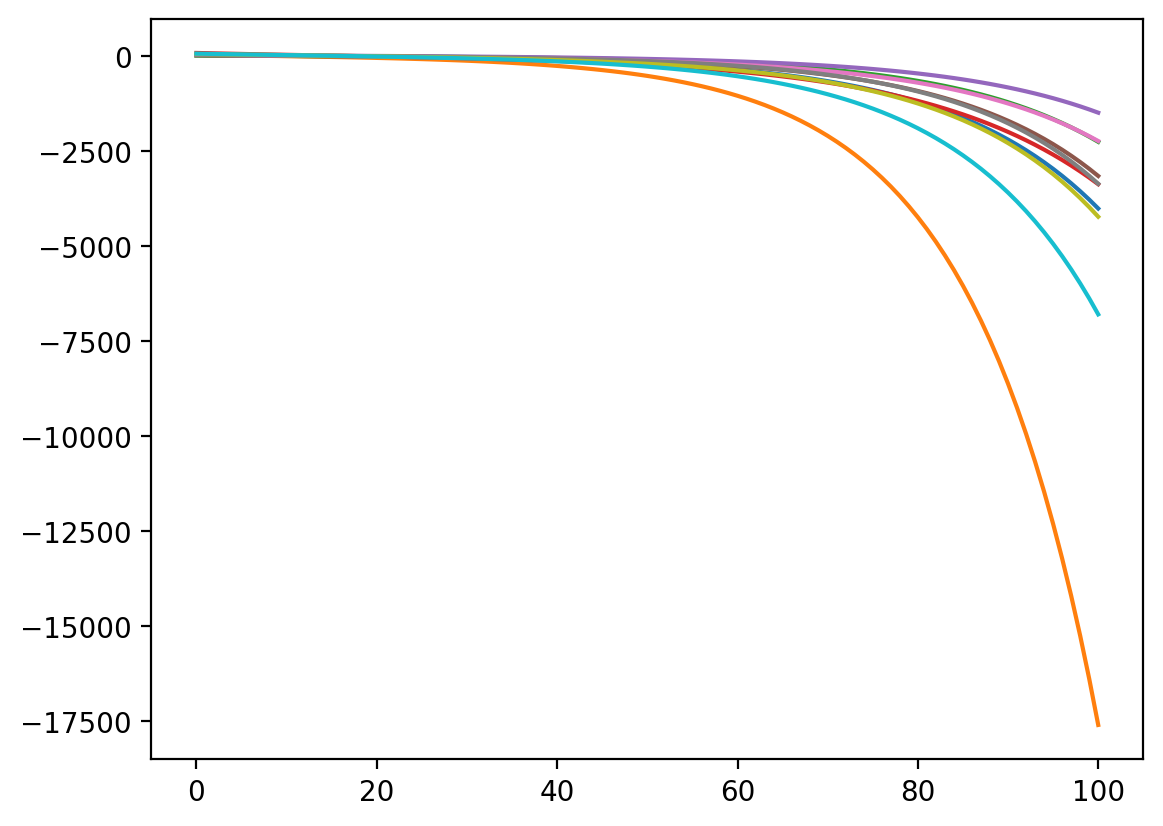

In [ ]:
for e in E[:10]:
    plt.plot(e);

# Hopfield + optax + equinox + diffrax

In [ ]:
! pip install -q --no-deps equinox diffrax jaxtyping lineax optimistix wadler-lindig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 4.6 MB/s eta 0:00:00


In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import itertools
import equinox as eqx
import optax
import diffrax
import time

from sklearn.model_selection import train_test_split, cross_val_score

from jax import grad, random, config, vmap, jit
from jax.lax import scan, dot_general
from jax.nn import relu, gelu, sigmoid, softmax, log_softmax
from jax.tree_util import tree_map, tree_flatten
from numpy import genfromtxt

from tqdm import tqdm

%config InlineBackend.figure_format='retina'

In [ ]:
class Hopfield(eqx.Module):
    W: jnp.array
    b: jnp.array

    def __init__(self, N_neurons, key):
        self.W = random.normal(key, (N_neurons, N_neurons)) / jnp.sqrt(N_neurons)
        self.b = jnp.zeros((N_neurons, ))

    def __call__(self, t, x, args):
        r = relu(x)
        return (self.W + self.W.T) @ r / 2 - x + self.b

    def energy(self, x):
        r = relu(x)
        E = (x - self.b) @ r - jnp.sum(r**2) / 2 - r @ (self.W + self.W.T) @ r / 4
        return E

In [ ]:
def integrate(model, x, dt, N_steps):
    x = diffrax.diffeqsolve(
      diffrax.ODETerm(model),
      diffrax.Dopri5(), #Runge-Kutta adaptive solver (Dormand-Prince 5th order method)
      t0=0,
      t1=1,
      dt0=dt,
      y0=x,
      stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-5),
      args=None
    ).ys[-1]
    return x

def loss_fn(model, x, y, dt, N_steps, N_classes):
    # last ten elements loss
    x_T = integrate(model, x, dt, N_steps)[-N_classes:]
    log_proba = log_softmax(x_T)
    return -log_proba[y]

def loss_fn1(model, x, y, dt, N_steps, N_classes):
    # linear layer loss
    key5 = random.PRNGKey(19)
    classification_layer = eqx.nn.Linear(64, 10, key5)
    x_T = integrate(model, x, dt, N_steps)
    classes = classification_layer(x_T)
    log_proba = log_softmax(classes)
    return -log_proba[y]

def batch_loss(model, x, y, dt, N_steps, N_classes):
    return jnp.mean(vmap(loss_fn1, in_axes=(None, 0, 0, None, None, None))(model, x, y, dt, N_steps, N_classes))

def accuracy(model, x, y, dt, N_steps, N_classes):
    x_T = integrate(model, x, dt, N_steps)[-N_classes:]
    log_proba = log_softmax(x_T)
    return jnp.argmax(log_proba) == y

@eqx.filter_jit
def update(model, x, y, opt_state, optimizer, dt, N_steps, N_classes):
    loss, grads = eqx.filter_value_and_grad(batch_loss)(model, x, y, dt, N_steps, N_classes)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

def load_data():
    my_data = genfromtxt('/content/sample_data/mnist_test.csv', delimiter=',')
    features = jnp.array(my_data[:, 1:], dtype=jnp.float32) / 255.0
    targets = jnp.array(my_data[:, 0], dtype=jnp.int32)
    return features, targets

def split_data(features, targets):
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


def split_in_batches(X_train, y_train, batch_size):
    num_samples = X_train.shape[0]
    num_batches = num_samples // batch_size

    # TODO: make dataloader to only save single batch at a time in RAM
    X_train = X_train[: num_batches * batch_size].reshape(num_batches, batch_size, -1)
    y_train = y_train[: num_batches * batch_size].reshape(num_batches, batch_size)

    return list(zip(X_train, y_train))


def train(epochs=1000, learning_rate=1e-3, batch_size=64, dt=1e-2, N_steps=100, N_classes=10):
    key = random.PRNGKey(33)
    features, targets = load_data()
    # TODO: batching for test data, because it can be big and not fit into GPU
    # also make batching with dataloader object for test
    X_train, X_test, y_train, y_test = split_data(features, targets)
    data_batches = split_in_batches(X_train, y_train, batch_size)
    # print(data_batches[0][0].shape[1])
    model = Hopfield(data_batches[0][0].shape[1], key)
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    accs = []

    for epoch in range(epochs):
        for x, y in data_batches:
            model, opt_state, loss = update(model, x, y, opt_state, optimizer, dt, N_steps, N_classes)
        # acc = jnp.mean(vmap(accuracy, in_axes=(None, 0, 0, None, None, None))(model, x, y, dt, N_steps, N_classes))
        acc = jnp.mean(
              vmap(accuracy, in_axes=(None, 0, 0, None, None, None))(model, X_test, y_test, dt, N_steps, N_classes)
            )
        # TODO: maybe put vmaped accuracy in a separate function?

        print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")
        accs.append(acc)

    return model, data_batches, accs

In [ ]:
model, data_batches, accs = train(epochs=1)

TypeError: Linear.__init__() missing 1 required keyword-only argument: 'key'

In [ ]:
key = random.PRNGKey(0)
model = Hopfield(N_neurons=3, key=key)

# Define inputs
x = jnp.array([3.0, 2.0, 3.0])  # Initial state of neurons
y = jnp.array([1, 2, 1])  # Class labels
dt = 0.1  # Step size for integration
N_steps = 10  # Number of integration steps
N_classes = 3  # Number of classes

# Compute loss
loss = loss_fn(model, x, y, dt, N_steps, N_classes)
# batch_loss = batch_loss(model, x, y, dt, N_steps, N_classes)
print("Loss:", loss)
# print("batch_loss:", batch_loss)

Loss: [ 4.052162 10.347645  4.052162]


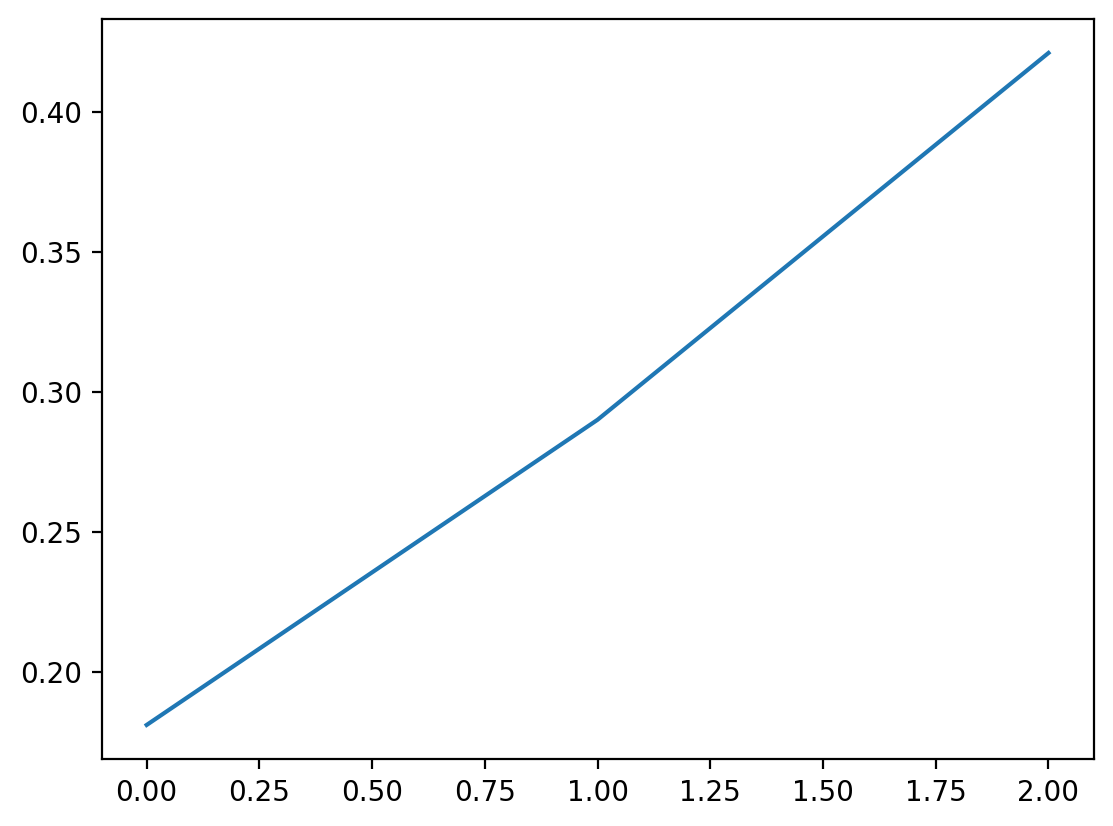

In [ ]:
plt.plot(accs)

In [ ]:
def integrate_trajectory(model, x, dt, N_steps, ts):
    x = diffrax.diffeqsolve(
        diffrax.ODETerm(model),
        diffrax.Dopri5(),
        t0=0,
        t1=1,
        dt0=dt,
        y0=x,
        stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-5),
        saveat=diffrax.SaveAt(ts=ts),
        args=None
    ).ys
    return x

In [ ]:
dt = 1e-2
N_steps = 100
ts = jnp.linspace(0, 1, 100)
batch_trajectory = vmap(integrate_trajectory, in_axes=(None, 0, None, None, None))(model, data_batches[0][0], dt, N_steps, ts)
# batch_trajectory.shape

In [ ]:
E = vmap(vmap(model.energy))(batch_trajectory)
# E.shape

<ipython-input-35-d671525b9f52>:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


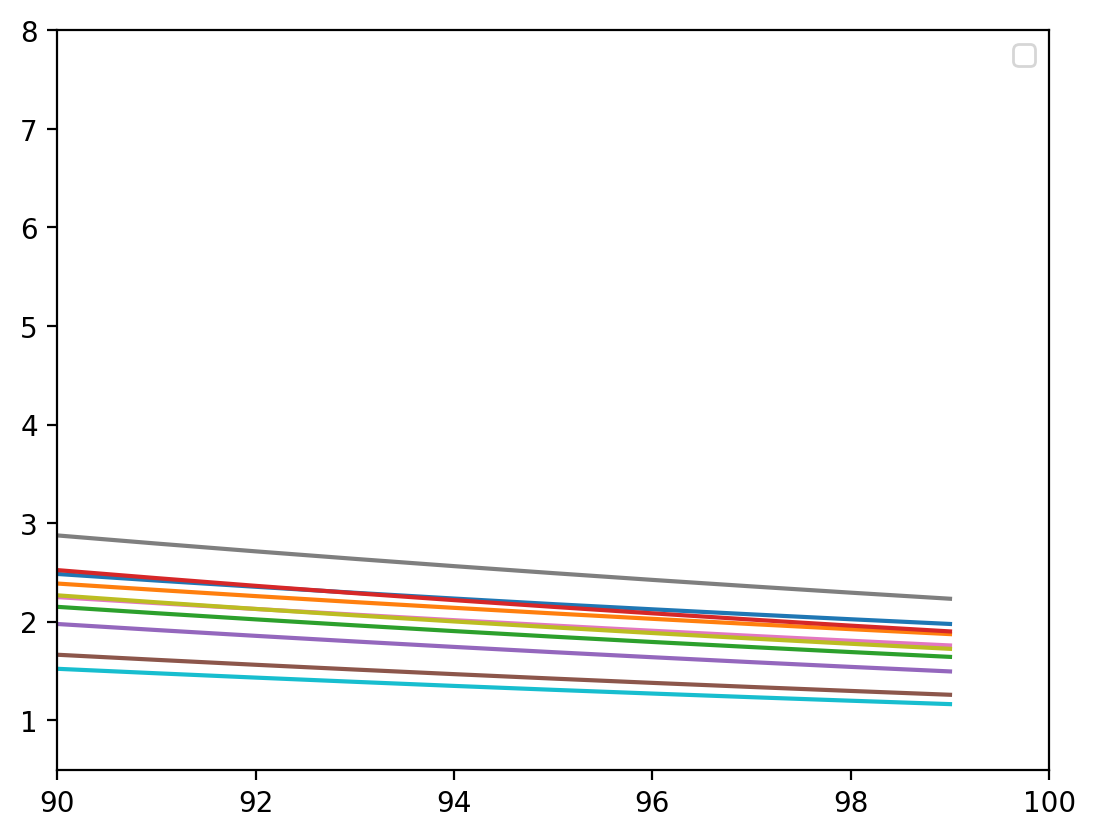

In [ ]:
plt.ylim(0.5, 8)
plt.xlim(90, 100)
for e in E[:10]:
    plt.legend()
    plt.plot(e);